In [155]:
import numpy as np
import matplotlib.pyplot as plt

from sympy import Matrix
from sympy.printing import latex
from IPython.display import display, Math

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.circuit.library import UnitaryGate, CXGate, CSwapGate, XGate
from qiskit.quantum_info import Operator, DensityMatrix, Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# Medidas

A medida projetiva na base computacinal corresponde a medição do estado quântico na base

$$
\{\ket{0}, \ket{1}\}
$$

para um qubit no estado

$$
\ket{\psi} = \alpha\ket{0} + \beta\ket{1}
$$

a medida projetiva colapsa o estado para

- $\ket{0}$ com probabilidade $|\alpha|^2$
- $\ket{1}$ com probabilidade $|\beta|^2$

No qiskit utilizamos o método `.measure()`.

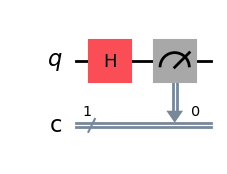

In [156]:
qc = QuantumCircuit(1, 1)

qc.h(0)

qc.measure(0, 0)

# Draw the circuit
qc.draw('mpl')

## Princípio da medida postergada

 Medidas podem ser sempre movidas de um estágio intermediário de um circuito quântico para o final do circuito. Se o resultado da medida é usado em qualquer estágio, então as operações controladas de forma clássica podem ser substituídas por operações condicionais quânticas.


Abaixo temos um exemplo com operações controladas por medidas de forma clássica e uma versão onde a medida é postergada.

**No circuito $qc_1$**:

1. Estado inicial
$$
    \ket{\psi} = \ket{q_1q_0} = \ket{00}
$$
2. Hadamard no qubit $0$
$$
H\ket{q_0} = \frac{1}{\sqrt{2}}(\ket{0}+\ket{1}) \implies \ket{\psi} = \frac{1}{\sqrt{2}}(\ket{00}+\ket{01})
$$
3. Medida em $q_0$
- 50% de chance de obtermos $\ket{00}$ e não aplicarmos o operador $X$.
- 50% de chance de obtermos $\ket{01}$ e aplicarmos o operador $X$ em $q_1$
$$
    X\otimes I\ket{01} = X\ket{0}\otimes I\ket{1} = \ket{11}.
$$
4. Portanto, $qc_1$ apresenta estado final $\ket{00}$ ou $\ket{11}$ com 50% de probabilidade cada.

**No circuito $qc_2$**:

1. Estado inicial
$$
    \ket{\psi} = \ket{q_1q_0} = \ket{00}
$$
2. Hadamard no qubit $0$
$$
H\ket{q_0} = \frac{1}{\sqrt{2}}(\ket{0}+\ket{1}) \implies \ket{\psi} = \frac{1}{\sqrt{2}}(\ket{00}+\ket{01})
$$
3. Aplica-se o operador CNOT com qubit de controle $q_0$ e qubit alvo $q_1$
$$
   CNOT\ket{q_1q_0} = \frac{1}{\sqrt{2}}(\ket{00}+\ket{11})
$$
4. Portanto, $qc_1$ apresenta estado final $\ket{00}$ ou $\ket{11}$ com 50% de probabilidade cada.

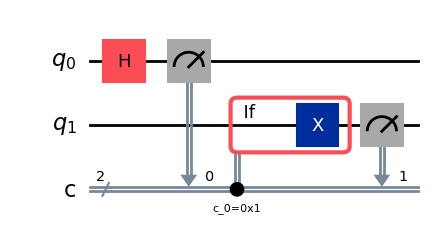

In [157]:
qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")

qc1 = QuantumCircuit(qr, cr)

qc1.h(qr[0])

qc1.measure(qr[0], cr[0])

with qc1.if_test((cr[0], 1)):
    qc1.x(1)

qc1.measure(qr[1], cr[1])

qc1.draw('mpl')

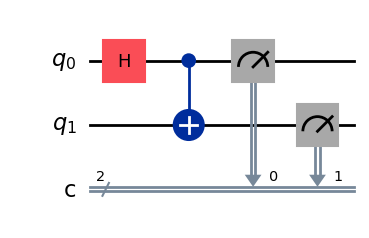

In [158]:
qc2 = QuantumCircuit(2, 2)

qc2.h(0)

qc2.cx(0, 1)

qc2.measure([0, 1], [0, 1])

qc2.draw('mpl')

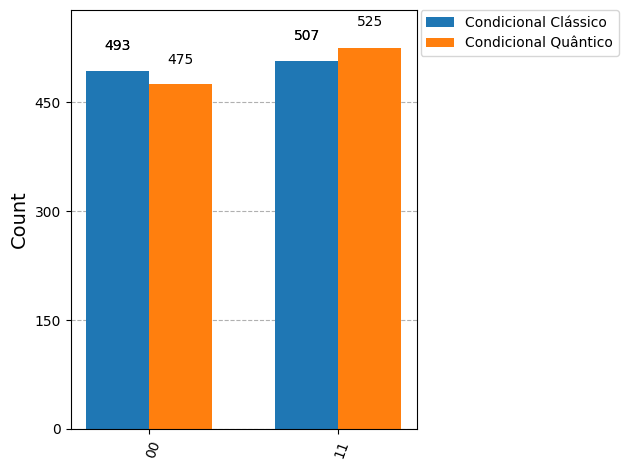

In [159]:
simulator = AerSimulator()

qc1 = transpile(qc1, simulator)
qc2 = transpile(qc2, simulator)

# Executar os dois circuitos
result1 = simulator.run(qc1, shots=1000).result().get_counts()
result2 = simulator.run(qc2, shots=1000).result().get_counts()

plot_histogram([result1, result2], legend=['Condicional Clássico', 'Condicional Quântico'])

### Teleporte Quântico

Relembrando, no teleporte quântico Alice e Bob compartilham um par EPR e Alice deseja enviar um qubit para Bob. Alice pode enviar apenas dois bits clássicos. Temos:

- $q_0$: O qubit que Alice deseja enviar para Bob, também chamado de $\ket{\psi}$.
- $q_1$: O qubit de Alice.
- $q_2$: o qubit de Bob.

os qubits $q_1$ e $q_2$ estão em um estado emaranhado

$$
\ket{q_1q_2} = \ket{\beta_{00}} = \frac{1}{\sqrt{2}}(\ket{00}+\ket{11})
$$

- $c_0$: o bit de resultado após Alice medir o estado $q_0$
- $c_0$: o bit de resultado após Alice medir o estado $q_1$

Existem quatro possibilidades:

1. $00$: Bob não precisa fazer nada, ou seja, $I\ket{q_0}$.
2. $01$: Bob aplica o operador $Z$, ou seja, $Z\ket{q_0}$.
3. $10$: Bob aplica o operador $X$, ou seja, $X\ket{q_0}$.
4. $11$: Bob aplica o operador $Z$ depois o operador $X$, ou seja, $XZ\ket{q_0}$.

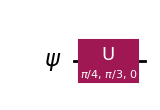

In [160]:
q = QuantumRegister(1, "ψ")
qcPsi = QuantumCircuit(q, name="U")

theta = np.pi/4
varphi = np.pi/3

qcPsi.u(theta, varphi, 0.0, 0)

qcPsi.draw("mpl")

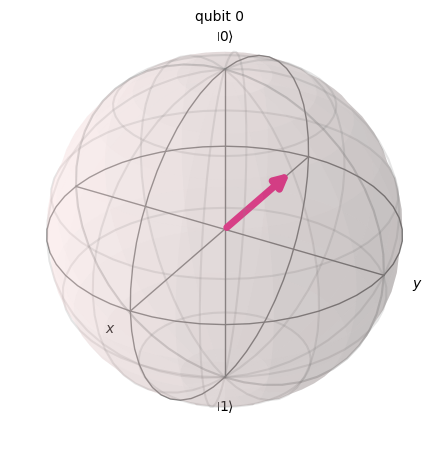

In [161]:
out_vector = Statevector(qcPsi) 
plot_bloch_multivector(out_vector)

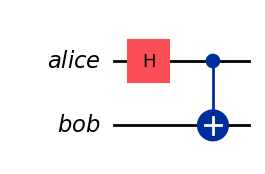

In [162]:
alice = QuantumRegister(1, "alice")
bob = QuantumRegister(1, "bob")

qcBell = QuantumCircuit(alice, bob, name="β00")

# Criação do par EPR entre q1 e q2
qcBell.h(0)
qcBell.cx(0, 1)

qcBell.draw("mpl")

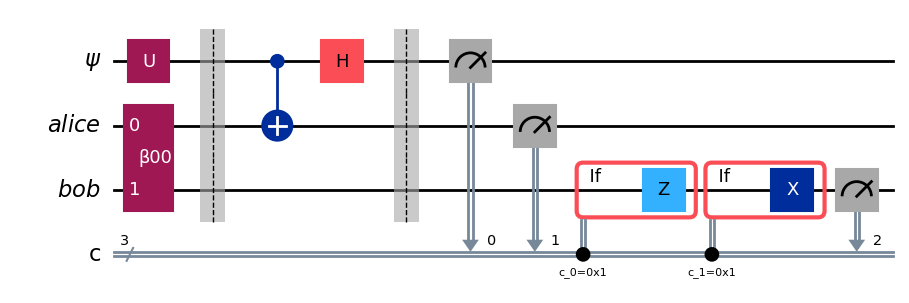

In [163]:
q = QuantumRegister(1, "ψ")

cr = ClassicalRegister(3, "c")
qc1 = QuantumCircuit(q, alice, bob, cr)

qc1.append(qcPsi, [0])
qc1.append(qcBell, [1,2])

qc1.barrier()

qc1.cx(0, 1)
qc1.h(0)

qc1.barrier()

# Medição intermediária
qc1.measure(0, 0)
qc1.measure(1, 1)

with qc1.if_test((cr[0], 1)):
    qc1.z(bob)

with qc1.if_test((cr[1], 1)):
    qc1.x(bob)

qc1.measure(2, 2)

qc1.draw('mpl')

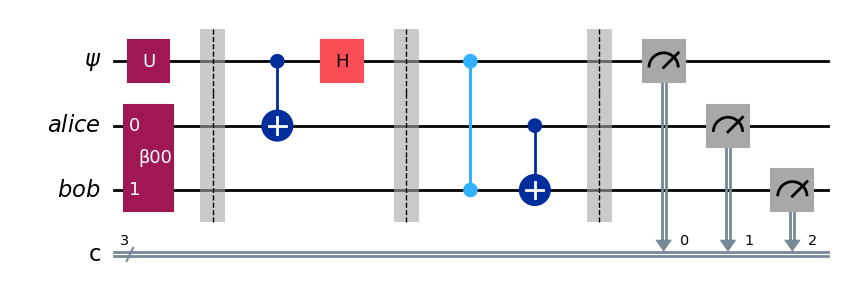

In [164]:
q = QuantumRegister(1, "ψ")
alice = QuantumRegister(1, "alice")
bob = QuantumRegister(1, "bob")

cr = ClassicalRegister(3, "c")
qc2 = QuantumCircuit(q, alice, bob, cr)

qc2.append(qcPsi, [0])
qc2.append(qcBell, [1,2])

qc2.barrier()

qc2.cx(0, 1)
qc2.h(0)

qc2.barrier()

qc2.cz(0, 2)
qc2.cx(1, 2)

qc2.barrier()

qc2.measure([0, 1, 2], [0, 1, 2])

qc2.draw("mpl")

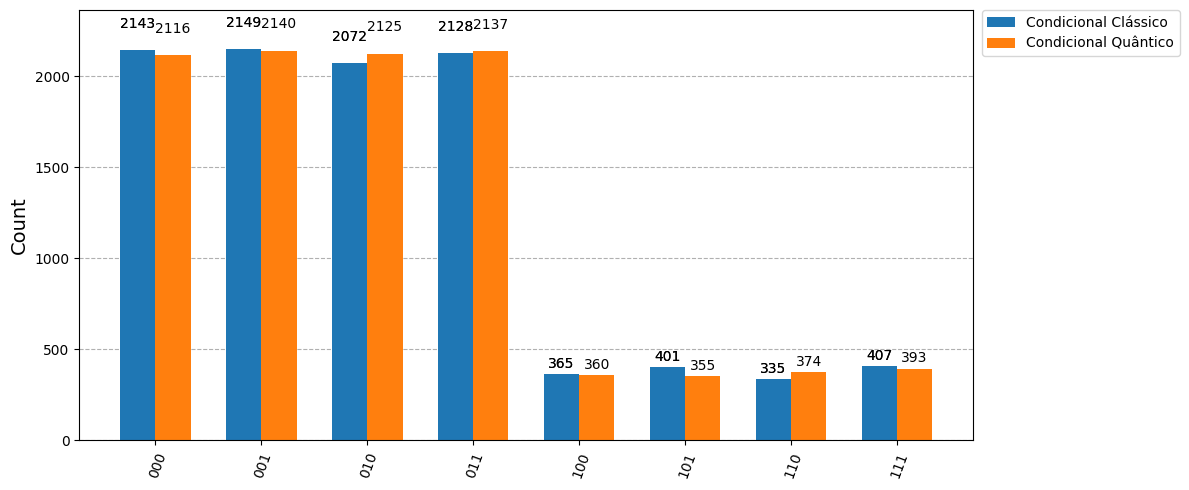

In [167]:
simulator = AerSimulator()

qc1 = transpile(qc1, simulator)
qc2 = transpile(qc2, simulator)

# Executar os dois circuitos
result1 = simulator.run(qc1, shots=10000).result().get_counts()
result2 = simulator.run(qc2, shots=10000).result().get_counts()

plot_histogram([result1, result2], legend=['Condicional Clássico', 'Condicional Quântico'], figsize=(12, 5))

## Princípio da medida implícita

Sem perda de generalidade qualquer "fio quântico" (que não tenha sido medido) ao final do circuito quântico, pode ser assumido como medido.